In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Descriptors import NumRadicalElectrons
import copy
import multiprocessing as mp

IPythonConsole.drawOptions.addAtomIndices = True


IPythonConsole.molSize = 400,400

import mol_functions as mf
import json

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


FileNotFoundError: Cannot find DGL C++ graphbolt library at /Users/valentinnovikov/miniforge3/envs/chem/lib/python3.9/site-packages/dgl/graphbolt/libgraphbolt_pytorch_2.5.1.dylib

In [ ]:
import importlib

importlib.reload(mf)

<module 'mol_functions' from 'C:\\Users\\Олег\\nmr_to_structure\\frags2mol\\mol_functions.py'>

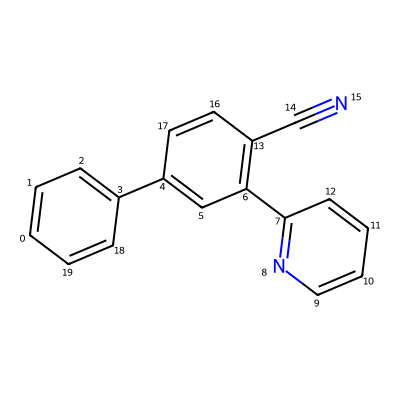

In [3]:
smiles = 'C([H])1C([H])=C([H])C(C2C([H])=C(C3N=C([H])C([H])=C([H])C=3[H])C(C#N)=C([H])C=2[H])=C([H])C=1[H]'
mol = Chem.MolFromSmiles(smiles)
mol

In [4]:
%%time
#to check  that nmr model was initialized
mf.get_predicted_ppm(mol)

CPU times: total: 516 ms
Wall time: 112 ms


array([118.86   , 127.89   , 123.44501, 128.58499, 137.61   , 149.59   ,
       127.91   , 127.92999, 121.265  , 134.76001, 126.455  , 139.75   ,
       145.47   , 155.20999, 111.38   , 145.11499], dtype=float32)

In [5]:
#generate fragments from mol
init_frags = mf.get_fp_frags(mol, radius = 2)
len(init_frags)

19

In [6]:
#filter out fragments existing in main dataset:
with open('fp2frags.json') as f:
    fp2frags = json.loads(f.read())

In [7]:
len(fp2frags)

5113

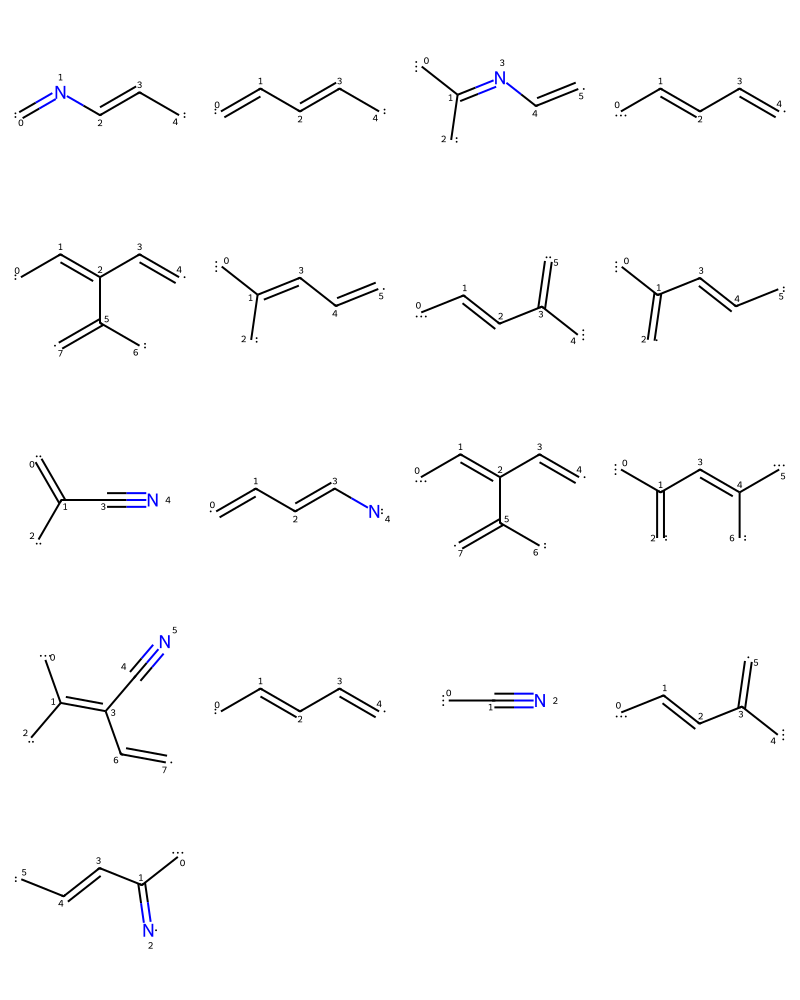

In [8]:
mols = [Chem.MolFromSmiles(x) for x in init_frags if x in fp2frags]
Draw.MolsToGridImage(mols, molsPerRow=4)

In [9]:
len(mols)

17

In [10]:
spectrum = [153.8, 148.9, 140.9, 140.8, 137.3, 135.9, 131.6, 130.4, 129.4, 128.1, 127.5, 126.0, 122.3, 122.1, 117.8, 110.4]

#задаем максимальное количество атомов углерода, которое мы готовы увидеть в молекуле
max_carbon_atoms = len(spectrum) *2

#задаем сколько атомов углерода должно быть в молекуле, чтобы имело смысл для нее предсказывать спектр 
prediction_treschold = int(len(spectrum)/2)+1 

In [21]:
#для работы в многопоточном режиме функцию надо инициализировать после создания списка молекул 
#и определения числа max_carbon_atoms. Сделано для того, чтобы можно было передавать только один аргумент: frag_1

def process_frag(frag_1, max_carbon_atoms=max_carbon_atoms, mols = mols):
    res_smiles = []
    res_mols = []
    cand_spec = []
    for frag_2 in mols:
        try:
            res = mf.merge_fragments(frag_1, frag_2)
            if res is not None and len(res) > 0:
                for molecule in res:
                    if molecule is not None:

                        if NumRadicalElectrons(molecule) < 8:
                            try:
                                #сюда как минимум входит сам фрагмент до циклизации
                                cyclized = mf.cyclize_rings(molecule, max_ring_size=6, check_aromatic = True) 
                                smileses = [Chem.MolToSmiles(x) for x in cyclized]

                                for fr, smiles in zip(cyclized, smileses):
                                    carb_atoms = mf.get_num_carbon_atoms(fr)
                                    if smiles not in res_smiles and carb_atoms < max_carbon_atoms:
                                        if carb_atoms >= prediction_treschold :
                                            closed_mol = mf.close_readicals(fr)
                                            predicted_ppm = mf.get_predicted_ppm(closed_mol)                                            
                                            mae, maxdif = mf.check_mae_realppm(spectrum, predicted_ppm, 
                                                                                  return_real_list = False)
                                            if mae < 10:
                                                res_mols.append(fr)
                                                res_smiles.append(smiles)         
                                                cand_spec.append({'smiles': smiles, 'predicted_ppm': predicted_ppm,
                                                               'mae': mae, 'maxdif': maxdif})
                                        else:
                                            res_mols.append(fr)
                                            res_smiles.append(smiles)
                                            cand_spec.append({'smiles': smiles, 'predicted_ppm': None,
                                                               'mae': None, 'maxdif': None})
                            except Exception as e:
                                pass

        except Exception as e:
#             pass
            print(e)
    return res_smiles, res_mols, cand_spec

In [22]:
len(mols)

17

In [23]:
%%time
#single process mode

#инициализируем исходный список, куда будем докидывать генерируемые молекулы
target_mols = copy.deepcopy(mols) #обновляемое на каждом шаге, служит базой, на которую налепляют новые фрагменты
target_smiles_list = [Chem.MolToSmiles(x) for x in target_mols] #постоянно пополняется
total_candidate_specs = [] #постоянно пополняется

while True:
    
    result = []
    for frag in target_mols:
        result.append(process_frag(frag))
    
    target_mols = []
    
    for item in result:
        for smiles, frag, cand_sp  in zip(*item):
            if smiles not in target_smiles_list:
                target_mols.append(frag)
                target_smiles_list.append(smiles)
                total_candidate_specs.append(cand_sp)
    print('New frags:', len(target_mols))
    
    if len(target_mols) == 0:
        break

New frags: 49
New frags: 28
New frags: 49
New frags: 59
New frags: 91
New frags: 94
New frags: 100
New frags: 123
New frags: 122
New frags: 120
New frags: 93
New frags: 100
New frags: 99
New frags: 83
New frags: 47
New frags: 17
New frags: 0
CPU times: total: 40min 13s
Wall time: 10min 58s


In [ ]:
%%time
#mp mode
#USE ONLY ON LINUX 
#инициализируем исходный список, куда будем докидывать генерируемые молекулы
target_mols = copy.deepcopy(mols) #обновляемое на каждом шаге, служит базой, на которую налепляют новые фрагменты
target_smiles_list = [Chem.MolToSmiles(x) for x in target_mols] #постоянно пополняется
total_candidate_specs = [] #постоянно пополняется

while True:
    
    with mp.Pool(20) as p: 
        result = p.map(process_frag, target_mols)   
    
    target_mols = []    
    for item in result:
        for smiles, frag, cand_sp  in zip(*item):
            if smiles not in target_smiles_list:
                target_mols.append(frag)
                target_smiles_list.append(smiles)
                total_candidate_specs.append(cand_sp)
    print('New frags:', len(target_mols))
    
    if len(target_mols) == 0:
        break

In [24]:
len(target_smiles_list)

1291

In [25]:
cand_spec = [x for x in total_candidate_specs if x['mae'] is not None]
len(cand_spec)

1193

In [26]:
precize = [x for x in cand_spec if (len(x['predicted_ppm'])<=len(spectrum) + 2 and len(x['predicted_ppm'])>=len(spectrum)-2)]


In [27]:
len(precize)

163

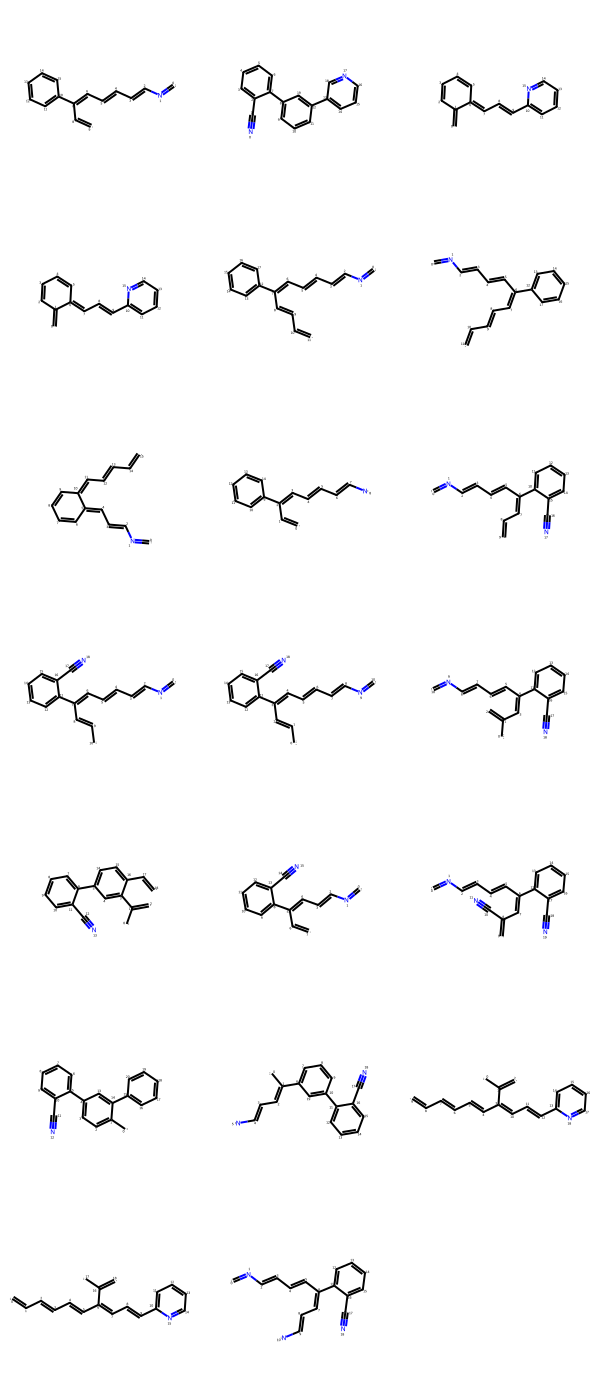

In [28]:
#пятая молекула довольно адекватно соответствует исходно запрошенной
forgrid = [Chem.MolFromSmiles(x['smiles'] )for x in sorted(precize, key = lambda x: x['mae'])[:20]]
Draw.MolsToGridImage(forgrid, molsPerRow=3)